In [1]:
import sys,os,time,random
import numpy as np
import matplotlib
matplotlib.use('Agg');
import matplotlib.pyplot as plt
plt.set_cmap('jet');

import theano
import theano.tensor as T 
import lasagne

import skimage
from skimage.io import imread, imsave
import pickle
import scipy

from os import walk
print "theano",theano.version.full_version
print "lasagne",lasagne.__version__

theano 1.0.1
lasagne 0.2.dev1


In [2]:
%matplotlib inline

In [3]:
import sys
import argparse

if len(sys.argv) == 3 and sys.argv[1] == "-f": #on jupyter
    sys.argv = ['']
    
parser = argparse.ArgumentParser(description='Count-ception')

parser.add_argument('-seed', type=int, nargs='?',default=0, help='random seed for split and init')
parser.add_argument('-stride', type=int, nargs='?',default=1, help='The args.stride at the initial layer')
parser.add_argument('-lr', type=float, nargs='?',default=0.00005, help='This will set the learning rate ')
parser.add_argument('-kern', type=str, nargs='?',default="gaus", help='This can be gaus or sq')
parser.add_argument('-cov', type=float, nargs='?',default=20, help='This is the covariance when kern=gaus')
parser.add_argument('-data', type=str, nargs='?',default="lab_img", help='Dataset folder')
parser.add_argument('-framesize', type=int, nargs='?',default=300, help='Size of the images processed at once')
parser.add_argument('-lf', type=str, nargs='?',default="l2", help='This can be l1, l2 or huber')
parser.add_argument('-patch_size', type=int, nargs='?',default="32", help='This depends on the size of object')
parser.add_argument('-sample_size', type=int, nargs='?',default="20", help='size for training and valid data')

args = parser.parse_args()
print args

Namespace(cov=20, data='lab_img', framesize=300, kern='gaus', lf='l2', lr=5e-05, patch_size=32, sample_size=20, seed=0, stride=1)


In [4]:
patch_size = args.patch_size
framesize = int(args.framesize)
noutputs = 1
job_id = "2"
ef = ((patch_size/args.stride)**2.0)

In [5]:
datasetfilename = (str(patch_size) + "-" + str(framesize) + "-" + args.kern + str(args.stride) 
                  + "-" + args.data + "-" + str(args.cov) + "-dataset.p")
print datasetfilename

32-300-gaus1-lab_img-20-dataset.p


In [6]:
# random.seed(args.seed)
# np.random.seed(args.seed)
# lasagne.random.set_rng(np.random.RandomState(args.seed))

In [7]:
## Initialize helper functions

In [8]:
# Generate GausImage for point (mx, my)
def genGausImage(width, mx, my, cov):
    x, y = np.mgrid[0:width, 0:width]
    pos = np.dstack((x, y))
    mean = [mx, my]
    cov = [[cov, 0], [0, cov]]
    rv = scipy.stats.multivariate_normal(mean, cov).pdf(pos)
    return rv/rv.sum()

# Only Take the pixel greater than 0.5 into consideration. See getLabelsCells()
def getDensity(width, markers):
    gaus_img = np.zeros((width,width))
    for k in range(width):
        for l in range(width):      
            if (markers[k,l] > 0.5):
                gaus_img += genGausImage(markers.shape[0],k,l,args.cov)
    return gaus_img

def getMarkersCells(labelPath): 
    #Normalize it
    labs = imread(labelPath)
    labs[labs>200] = 255
    if len(labs.shape) == 2:
        lab = labs[:,:]/255
    elif len(labs.shape) == 3:
        lab = labs[:,:,0]/255
    else:
        print "unknown label format"
    return lab

# noutput = 1
def getCellCountCells(markers,(x,y,h,w)):
    counts = [0] * noutputs
    for i in range(noutputs):
        counts[i] = (markers[y:y+h,x:x+w] >= 0.5).sum()
        #types[i] = (markers[y:y+h,x:x+w] != -1).sum()
    return counts

def getLabelsCells(markers, img_pad, base_x, base_y):
    
    height = ((img_pad.shape[0])/args.stride)
    width = ((img_pad.shape[1])/args.stride)
#     print "label size: ", height, width
    labels = np.zeros((noutputs, height, width))
    if (args.kern == "sq"):
        for y in range(0,height):
            for x in range(0,width):
                count = getCellCountCells(markers,(x*args.stride,y*args.stride,patch_size,patch_size))  
                for i in range(0,noutputs):
                    labels[i][y][x] = count[i]

    
    elif (args.kern == "gaus"):
        for i in range(0,noutputs):
            labels[i] = getDensity(width, markers)
    

    count_total = getCellCountCells(markers,(0,0,args.framesize+patch_size,args.framesize+patch_size))
    return labels, count_total

#return the original img, a density map for this image, and the count of object of this image
def getTrainingExampleCells(img_raw, labelPath, base_x,  base_y):
    
    img = img_raw[base_y:base_y+args.framesize, base_x:base_x+args.framesize]
    img_pad = np.pad(img[:,:,0],(patch_size)/2, "constant", constant_values=0) # Only check the R value for RGB
    
    markers = getMarkersCells(labelPath)
#     print "markers 1: ", markers.shape
    markers = markers[base_y:base_y+args.framesize, base_x:base_x+args.framesize]
#     print "markers 2: ", markers.shape
    markers = np.pad(markers, (patch_size)/2, "constant", constant_values=0)
#     print "markers 3: ", markers.shape
    
    labels, count  = getLabelsCells(markers, img_pad, base_x, base_y)
    return img, labels, count

In [9]:
## Build Network

In [10]:
from lasagne.layers.normalization import BatchNormLayer
from lasagne.layers import InputLayer, ConcatLayer, Conv2DLayer

input_var = T.tensor4('inputs')
input_var_ex = T.ivector('input_var_ex')

def ConvFactory(data, num_filter, filter_size, pad=0, nonlinearity=lasagne.nonlinearities.leaky_rectify):
    data = lasagne.layers.batch_norm(
        Conv2DLayer(
            data, num_filters=num_filter,
            filter_size=filter_size,
            stride=args.stride, pad=pad,
            nonlinearity=nonlinearity,
            W=lasagne.init.GlorotUniform(gain='relu'))
    )
    return data

def SimpleFactory(data, ch_1x1, ch_3x3):
    conv1x1 = ConvFactory(data=data, filter_size=1, pad=0, num_filter=ch_1x1)
    conv3x3 = ConvFactory(data=data, filter_size=3, pad=1, num_filter=ch_3x3) 
    concat = ConcatLayer([conv1x1, conv3x3])
    return concat


input_shape = (None, 3, framesize, framesize)
img = InputLayer(shape=input_shape, input_var=input_var[input_var_ex])
net = img

print net.output_shape
net = ConvFactory(net, filter_size=3, num_filter=64, pad=patch_size)
print net.output_shape
net = SimpleFactory(net, 16, 16)
print net.output_shape
net = SimpleFactory(net, 16, 32)
print net.output_shape
net = ConvFactory(net, filter_size=14, num_filter=16) 
print net.output_shape
net = SimpleFactory(net, 112, 48)
print net.output_shape
net = SimpleFactory(net, 64, 32)
print net.output_shape
net = SimpleFactory(net, 40, 40)
print net.output_shape
net = SimpleFactory(net, 32, 96)
print net.output_shape
net = ConvFactory(net, filter_size=18, num_filter=32) 
print net.output_shape
net = ConvFactory(net, filter_size=1, pad=0, num_filter=64)
print net.output_shape
net = ConvFactory(net, filter_size=1, pad=0, num_filter=64)
print net.output_shape
net = ConvFactory(net, filter_size=1, num_filter=1)
print net.output_shape


(None, 3, 300, 300)
(None, 64, 362, 362)
(None, 32, 362, 362)
(None, 48, 362, 362)
(None, 16, 349, 349)
(None, 160, 349, 349)
(None, 96, 349, 349)
(None, 80, 349, 349)
(None, 128, 349, 349)
(None, 32, 332, 332)
(None, 64, 332, 332)
(None, 64, 332, 332)
(None, 1, 332, 332)


In [11]:
prediction = lasagne.layers.get_output(net, deterministic=True)
prediction_count = (prediction/ef).sum(axis=(2,3))

classify = theano.function([input_var, input_var_ex], prediction)

In [12]:
## Read in data

In [13]:
import glob
imgs = []
for filename in glob.iglob(args.data + "/*_dot.png"):
    imgg = filename.replace("_dot","")
    imgs.append([imgg,filename])
    
if len(imgs) == 0:
    print "Issue with dataset"
    sys.exit()

In [14]:
## code to debug data generation

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 9)
imgPath,labelPath,x,y = imgs[9][0],imgs[9][1], 2200, 300
#imgPath,labelPath,x,y = imgs[0][0], imgs[0][1], 100,200

print imgPath, labelPath

im = imread(imgPath)
img_raw_raw = im #grayscale

img_raw = scipy.misc.imresize(img_raw_raw, (int(img_raw_raw.shape[0]), int(img_raw_raw.shape[1])))
print img_raw_raw.shape," ->>>>", img_raw.shape

print "img_raw",img_raw.shape
img, lab, count = getTrainingExampleCells(img_raw, labelPath, x, y)
print "count", count

markers = getMarkersCells(labelPath)
markers = markers[y:y+framesize, x:x+framesize]
count = getCellCountCells(markers, (0, 0, framesize,framesize))
print "count", count, 'markers max', markers.max()

pcount = classify([img.transpose((2,0,1))], [0])[0] #Feed the R value into network
lab_est = [(np.rint(l.sum())).astype(np.int) for l in lab]
pred_est = [(l.sum()/ef).astype(np.int) for l in pcount]

print "img shape",  img.shape
print "label shape", lab.shape
print "label est ",lab_est," --> predicted est ",pred_est


lab_img/68.png lab_img/68_dot.png


__main__:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(1800, 2700, 3)  ->>>> (1800, 2700, 3)
img_raw (1800, 2700, 3)
count [0]
count [0] markers max 0


In [ ]:
fig = plt.Figure(figsize=(18, 9), dpi=160)
gcf = plt.gcf()
gcf.set_size_inches(18, 15)
fig.set_canvas(gcf.canvas)

ax2 = plt.subplot2grid((2,4), (0, 0), colspan=2)
ax3 = plt.subplot2grid((2,4), (0, 2), colspan=3)
ax4 = plt.subplot2grid((2,4), (1, 2), colspan=3)
ax5 = plt.subplot2grid((2,4), (1, 0), rowspan=1)
ax6 = plt.subplot2grid((2,4), (1, 1), rowspan=1)

ax2.set_title("Input Image")
ax2.imshow(img, interpolation='none',cmap='Greys_r');
ax3.set_title("Regression target, {}x{} sliding window.".format(patch_size, patch_size))
ax3.imshow(np.concatenate((lab),axis=1), interpolation='none');
#ax3.imshow(lab[0], interpolation='none')

ax4.set_title("Predicted counts")
ax4.imshow(np.concatenate((pcount),axis=1), interpolation='none');

ax5.set_title("Real " + str(lab_est))
ax5.set_ylim((0, np.max(lab_est)*2))
ax5.set_xticks(np.arange(0, noutputs, 1.0))
ax5.bar(range(noutputs),lab_est, align='center')
ax6.set_title("Pred " + str(pred_est))
ax6.set_ylim((0, np.max(lab_est)*2))
ax6.set_xticks(np.arange(0, noutputs, 1.0))
ax6.bar(range(noutputs),pred_est, align='center')

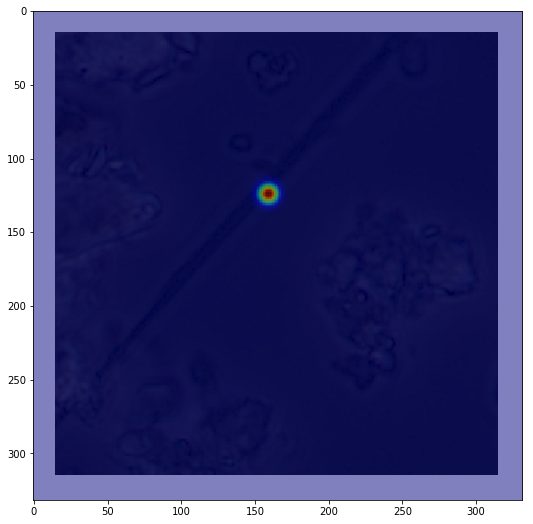

In [17]:
img_pad = np.asarray([np.pad(img[:,:,i],(patch_size-1)/2, "constant", constant_values=255) for i in range(img[0,0].shape[0])])
img_pad = img_pad.transpose((1,2,0))
plt.imshow(img_pad);
plt.imshow(lab[0], alpha=0.5);

In [18]:
# Read data into dataset

In [19]:
for path in imgs: 
    if (not os.path.isfile(path[0])):
        print path, "bad", path[0]
    if (not os.path.isfile(path[1])):
        print path, "bad", path[1]

In [20]:
dataset = []
if (os.path.isfile(datasetfilename)):
    print "reading", datasetfilename
    dataset = pickle.load(open(datasetfilename, "rb" ))
else:
    dataset_x = []
    dataset_y = []
    dataset_c = []
    print len(imgs)
    for path in imgs: 

        imgPath = path[0]
        print imgPath

        im = imread(imgPath)
        img_raw_raw = im
        
        img_raw = scipy.misc.imresize(img_raw_raw, (int(img_raw_raw.shape[0]),int(img_raw_raw.shape[1])))
#         print img_raw_raw.shape," ->>>>", img_raw.shape

        labelPath = path[1]
        for base_x in range(0,img_raw.shape[0],framesize):
            for base_y in range(0,img_raw.shape[1],framesize):
                
                if (img_raw.shape[1] - base_y < framesize) or (img_raw.shape[0] - base_x < framesize):
                    print "!!!! Not adding image because size is" , img_raw.shape[1] - base_y, img_raw.shape[0] - base_x
                    continue
                    
                img, lab, count = getTrainingExampleCells(img_raw, labelPath, base_y, base_x)

                    
                if img.shape[0:2] != (framesize,framesize):
                    print "!!!! Not adding image because size is" , img.shape[0:2]
                    
                else :   
                    lab_est = [(l.sum()/ef).astype(np.int) for l in lab]
                
#                     assert np.allclose(count,lab_est, 0)
                    if count[0] > 0:
                        dataset.append((img,lab,count))
                        print "count ", count[0]
#                     print "lab_est", lab_est, "img shape", img.shape, "label shape", lab.shape
                        sys.stdout.flush()
                    
#         print "dataset size", len(dataset)
                    
    print "writing", datasetfilename
    out = open(datasetfilename, "wb",0)
    pickle.dump(dataset, out)
    out.close()
print "DONE"

15
lab_img/7.png


__main__:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


count  1
count  1
count  1
count  1
count  1
count  1
lab_img/62.png
count  1
count  1
count  1
count  1
lab_img/63.png
count  1
count  1
count  1
count  1
count  1
lab_img/68.png
count  1
count  1
count  1
count  1
count  1
lab_img/66.png
count  1
count  1
count  1
count  1
lab_img/9.png
count  1
count  1
count  1
count  1
count  1
count  1
count  1
lab_img/8.png
count  1
count  2
count  1
lab_img/67.png
count  1
count  1
count  1
count  1
count  1
lab_img/5.png
count  1
count  1
count  1
count  2
count  1
count  1
lab_img/6.png
count  1
count  1
count  1
count  1
lab_img/65.png
count  1
count  1
count  1
count  1
count  1
lab_img/61.png
count  1
count  1
count  1
count  1
count  2
count  1
count  1
lab_img/64.png
count  1
count  1
lab_img/60.png
count  1
count  1
count  1
count  1
count  1
lab_img/69.png
count  1
count  1
writing 32-300-gaus1-lab_img-20-dataset.p
DONE


In [21]:
#np_dataset = np.asarray(dataset)

np.random.shuffle(dataset)
np_dataset_x = np.asarray([d[0] for d in dataset], dtype=theano.config.floatX)
np_dataset_y = np.asarray([d[1] for d in dataset], dtype=theano.config.floatX)
np_dataset_c = np.asarray([d[2] for d in dataset], dtype=theano.config.floatX)

print len(dataset)
np_dataset_x = np_dataset_x.transpose((0,3,1,2))

print "np_dataset_x", np_dataset_x.shape
print "np_dataset_y", np_dataset_y.shape
print "np_dataset_c", np_dataset_c.shape

70
np_dataset_x (70, 3, 300, 300)
np_dataset_y (70, 1, 332, 332)
np_dataset_c (70, 1)


In [22]:
length = len(np_dataset_x)

n = args.sample_size

np_dataset_x_train = np_dataset_x[0:n]
np_dataset_y_train = np_dataset_y[0:n]
np_dataset_c_train = np_dataset_c[0:n]
print "np_dataset_x_train", len(np_dataset_x_train)

np_dataset_x_valid = np_dataset_x[n:2*n]
np_dataset_y_valid = np_dataset_y[n:2*n]
np_dataset_c_valid = np_dataset_c[n:2*n]
print "np_dataset_x_valid", len(np_dataset_x_valid)

np_dataset_x_test = np_dataset_x[-20:]
np_dataset_y_test = np_dataset_y[-20:]
np_dataset_c_test = np_dataset_c[-20:]
print "np_dataset_x_test", len(np_dataset_x_test)

np_dataset_x_train 20
np_dataset_x_valid 20
np_dataset_x_test 20


In [23]:
# Overview of data

In [24]:
print "number of counts total ", np_dataset_c.sum()
print "number of counts on average ", np_dataset_c.mean(), "+-", np_dataset_c.std()
print "counts min:", np_dataset_c.min(), "max:", np_dataset_c.max()

number of counts total  73.0
number of counts on average  1.0428572 +- 0.20253496
counts min: 1.0 max: 2.0


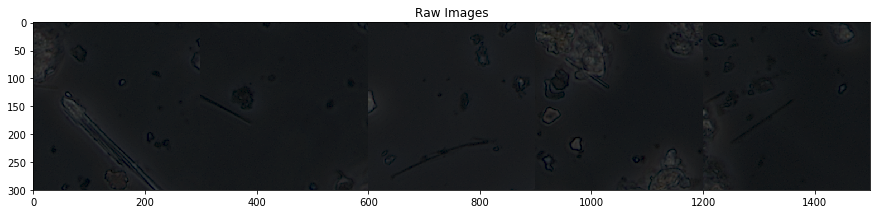

In [25]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Raw Images")
plt.imshow(np.concatenate(np_dataset_x_train[:5].astype(np.uint8).transpose((0,2,3,1)),axis=1), interpolation='none');

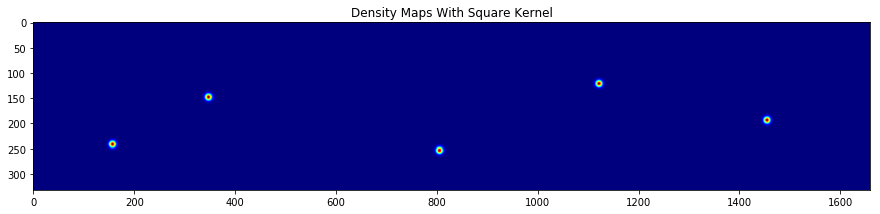

In [26]:
plt.title("Density Maps With Square Kernel")
plt.imshow(np.concatenate(np_dataset_y_train[:5,0],axis=1), interpolation='none');

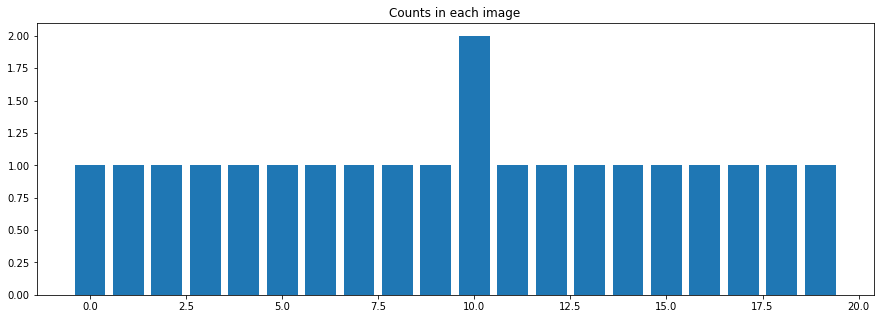

In [27]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Counts in each image")
plt.bar(range(len(np_dataset_c_train)),np_dataset_c_train.flatten());

In [28]:
print "Total cells in training", np.sum(np_dataset_c_train[0:], axis=0)
print "Total cells in validation", np.sum(np_dataset_c_valid[0:], axis=0)
print "Total cells in testing", np.sum(np_dataset_c_test[0:], axis=0)

Total cells in training [21.]
Total cells in validation [20.]
Total cells in testing [22.]


In [29]:
def processImages(name, i):
    fig = plt.Figure(figsize=(18, 9), dpi=160)
    gcf = plt.gcf()
    gcf.set_size_inches(18, 15)
    fig.set_canvas(gcf.canvas)
    
    (img, lab, count) = dataset[i]
    
    #print str(i),count
    pcount = classify([img.transpose((2,0,1))], [0])[0]
    
#     lab_est = [(l.sum()/(ef)).astype(np.int) for l in lab]
    lab_est = count[0]
    #print lab_est
    
    pred_est = [(l.sum()/(ef)).astype(np.int) for l in pcount]
    
    print str(i),"label est ",lab_est," --> predicted est ",pred_est

    ax2 = plt.subplot2grid((2,6), (0, 0), colspan=2)
    ax3 = plt.subplot2grid((2,6), (0, 2), colspan=5)
    ax4 = plt.subplot2grid((2,6), (1, 2), colspan=5)
    ax5 = plt.subplot2grid((2,6), (1, 0), rowspan=1)
    ax6 = plt.subplot2grid((2,6), (1, 1), rowspan=1)

    ax2.set_title("Input Image")
    ax2.imshow(img, interpolation='none', cmap='Greys_r')
    ax3.set_title("Regression target, {}x{} sliding window.".format(patch_size, patch_size))
    ax3.imshow(np.concatenate((lab),axis=1), interpolation='none')
    ax4.set_title("Predicted counts")
    ax4.imshow(np.concatenate((pcount),axis=1), interpolation='none')

    ax5.set_title("Real " + str(lab_est))
    ax5.set_ylim((0, np.max(lab_est)*2))
    ax5.set_xticks(np.arange(0, noutputs, 1.0))
    ax5.bar(range(noutputs),lab_est, align='center')
    ax6.set_title("Pred " + str(pred_est))
    ax6.set_ylim((0, np.max(lab_est)*2))
    ax6.set_xticks(np.arange(0, noutputs, 1.0))
    ax6.bar(range(noutputs),pred_est, align='center')
    if not os.path.exists('images-cell'): 
        os.mkdir('images-cell')
    fig.savefig('images-cell/image-' + str(i) + "-" + name + '.png', bbox_inches='tight', pad_inches=0)


In [30]:
import pickle, os

directory = "network-temp/"
ext = "countception.p"

if not os.path.exists(directory):
    os.makedirs(directory)
    
def save_network(net,name):
    pkl_params = lasagne.layers.get_all_param_values(net, trainable=True)
    out = open(directory + str(name) + ext, "w", 0) #bufsize=0
    pickle.dump(pkl_params, out)
    out.close()

def load_network(net,name):
    all_param_values = pickle.load(open(directory + str(name) + ext, "r" ))
    lasagne.layers.set_all_param_values(net, all_param_values, trainable=True)

In [31]:
#test accuracy
def test_perf(dataset_x, dataset_y, dataset_c):

    testpixelerrors = []
    testerrors = []
    bs = 1
    for i in range(0,len(dataset_x), bs):
#         print i
        pcount = classify(dataset_x,range(i,i+bs))
        pixelerr = np.abs(pcount - dataset_y[i:i+bs]).mean(axis=(2,3))
        testpixelerrors.append(pixelerr)
        
        pred_est = (pcount/(ef)).sum(axis=(1,2,3))
        err = np.abs(dataset_c[i:i+bs].flatten()-pred_est)
        
        testerrors.append(err)
    
    return np.abs(testpixelerrors).mean(), np.abs(testerrors).mean()

In [32]:
# Train n

In [33]:
target_var = T.tensor4('target')
lr = theano.shared(np.array(args.lr, dtype=theano.config.floatX))

#Mean Absolute Error is computed between each count of the count map
l1_loss = T.abs_(prediction - target_var[input_var_ex])
# L2 loss
l2_loss = (prediction - target_var[input_var_ex])**2
# Huber loss
delta = 0.2
d = prediction - target_var[input_var_ex]
a = 0.5 * (d**2)
b = delta * (abs(d) - delta / 2.)
huber_loss = T.switch(abs(d) <= delta, a, b)

#Mean Absolute Error is computed for the overall image prediction
prediction_count2 =(prediction/ef).sum(axis=(2,3))
mae_loss = T.abs_(prediction_count2 - (target_var[input_var_ex]/ef).sum(axis=(2,3))) 

if args.lf == "l1":
    loss = l1_loss.mean()
elif args.lf == "l2":
    loss = l2_loss.mean()
elif args.lf == "huber":
    loss = huber_loss.mean()   

params = lasagne.layers.get_all_params(net, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=lr)

train_fn = theano.function([input_var_ex], [loss,mae_loss], updates=updates,
                         givens={input_var:np_dataset_x_train, target_var:np_dataset_y_train})

print "DONE compiling theano functons"

DONE compiling theano functons


In [34]:
#lr.set_value(0.00005)
best_valid_err = 99999999
best_test_err = 99999999
epoch = 0

In [35]:
# Training
batch_size = 4

print "batch_size", batch_size
print "lr", lr.eval()

datasetlength = len(np_dataset_x_train)
print "datasetlength",datasetlength

for epoch in range(epoch, 20):
    start_time = time.time()

    epoch_err_pix = []
    epoch_err_pred = []
    todo = range(datasetlength)    
    
    for i in range(0,datasetlength, batch_size):
        ex = todo[i:i+batch_size]

        train_start_time = time.time()
        err_pix,err_pred = train_fn(ex)
        train_elapsed_time = time.time() - train_start_time

        epoch_err_pix.append(err_pix)
        epoch_err_pred.append(err_pred)

    valid_pix_err, valid_err = test_perf(np_dataset_x_valid, np_dataset_y_valid, np_dataset_c_valid)

    # a threshold is used to reduce processing when we are far from the goal
    if (valid_err < 200 and valid_err < best_valid_err):
        best_valid_err = valid_err
        best_test_err = test_perf(np_dataset_x_test, np_dataset_y_test,np_dataset_c_test)
        print "OOO best test (err_pix, err_pred)", best_test_err, ",epoch",epoch
        save_network(net,"best_valid_err" + args.lf + "_" + job_id)


    elapsed_time = time.time() - start_time
    err = np.mean(epoch_err_pix)
    acc = np.mean(np.concatenate(epoch_err_pred))
    
    if epoch % 5 == 0:
        print "#" + str(epoch) + "#(err_pix:" + str(np.around(err,6)) + ",err_pred:" +  str(np.around(acc,3)) + "),valid(err_pix:" + str(np.around(valid_pix_err,3)) + ",err_pred:" + str(np.around(valid_err,3)) +"),(time:" + str(np.around(elapsed_time,3)) + "sec)"

    #visualize training
    #processImages(str(epoch) + '-cell',0)

print "#####", "best_test_acc", best_test_err, args

batch_size 4
lr 5e-05
datasetlength 20
OOO best test (err_pix, err_pred) (0.10503457, 8.413098) ,epoch 0
#0#(err_pix:63.320442,err_pred:397.699),valid(err_pix:0.104,err_pred:8.218),(time:49.817sec)
##### best_test_acc (0.10503457, 8.413098) Namespace(cov=20, data='lab_img', framesize=300, kern='gaus', lf='l2', lr=5e-05, patch_size=32, sample_size=20, seed=0, stride=1)


In [36]:
print "Done"

Done


In [38]:
#load best network
load_network(net,"best_valid_err" + args.lf + "_" + job_id)

In [39]:
def compute_counts(dataset_x):
    bs = 1
    ests = []
    for i in range(0,len(dataset_x), bs):
        pcount = classify(dataset_x,range(i,i+bs))
        pred_est = (pcount/(ef)).sum(axis=(1,2,3))        
        ests.append(pred_est)
    return ests

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-6.9310145, -5.856069, -6.91696, -6.9264264, -5.9180965, -6.0172853, -6.989607, -6.7151737, -5.7558265, -7.5207615, -7.0341682, -5.9751644, -5.890237, -7.075213, -6.3253484, -6.513205, -8.334799, -6.33894, -7.554835, -7.51815]


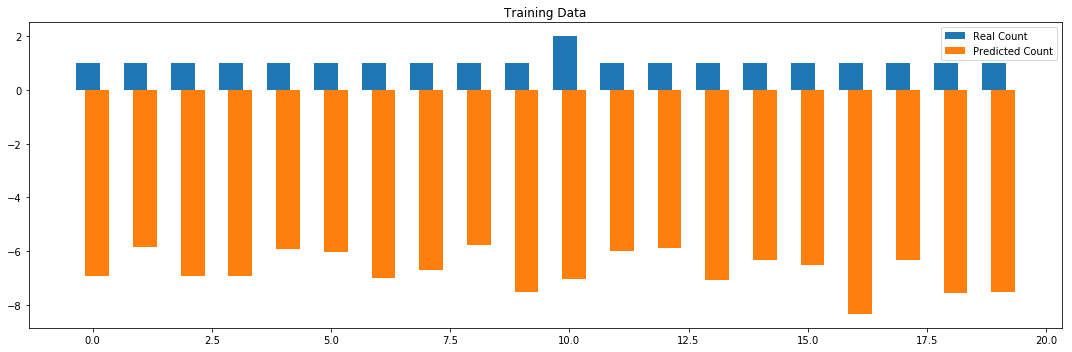

In [40]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Training Data")
pcounts = compute_counts(np_dataset_x_train)
flat_list = [item for sublist in pcounts for item in sublist]
print np_dataset_c_train.flatten()
print flat_list
plt.bar(np.arange(len(np_dataset_c_train))-0.1,np_dataset_c_train.flatten(), width=0.5, label="Real Count");
plt.bar(np.arange(len(np_dataset_c_train))+0.1,flat_list, width=0.5,label="Predicted Count");
plt.tight_layout()
plt.legend()

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-7.6721225, -8.100433, -7.590837, -7.7013497, -8.21288, -7.7378078, -6.933436, -6.3181334, -7.5735364, -7.091035, -6.686463, -8.596961, -8.451829, -7.2637744, -6.8201027, -6.069354, -6.821271, -6.6152887, -5.8599, -6.241455]


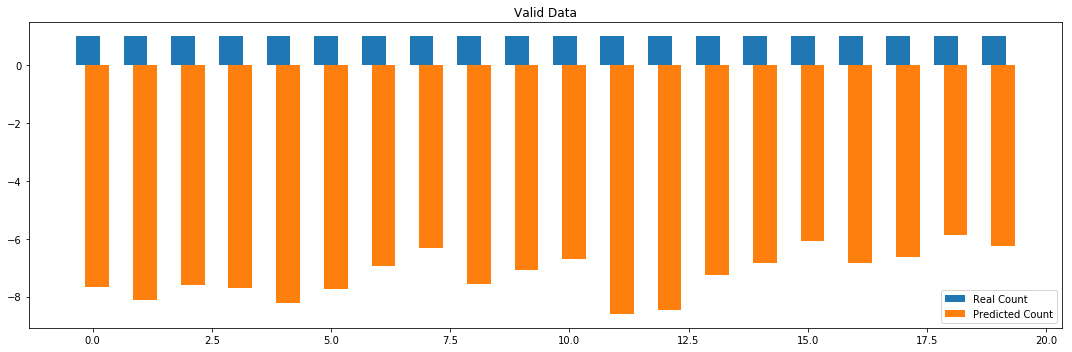

In [41]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Valid Data")
pcounts = compute_counts(np_dataset_x_valid)
flat_list = [item for sublist in pcounts for item in sublist]
print np_dataset_c_valid.flatten()
print flat_list
plt.bar(np.arange(len(np_dataset_c_valid))-0.1,np_dataset_c_valid.flatten(), width=0.5, label="Real Count");
plt.bar(np.arange(len(np_dataset_c_valid))+0.1,flat_list, width=0.5,label="Predicted Count");
plt.tight_layout()
plt.legend()

[1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.]
[-7.9256434, -8.522379, -7.0448556, -6.9334846, -7.134815, -7.0536165, -6.2062974, -6.4547815, -7.4908514, -7.216231, -7.516008, -7.0388036, -8.514201, -8.345724, -6.7886553, -7.6254377, -8.052017, -6.79694, -5.8766174, -7.724602]


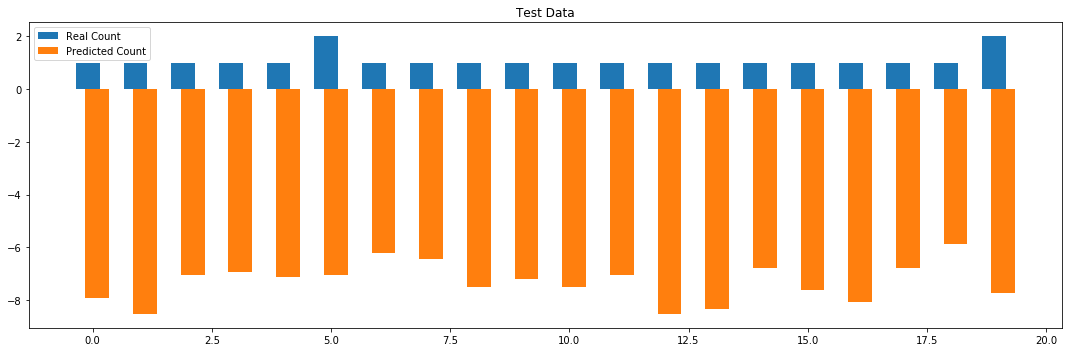

In [42]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Test Data")
pcounts = compute_counts(np_dataset_x_test)
flat_list = [item for sublist in pcounts for item in sublist]
print np_dataset_c_test.flatten()
print flat_list
plt.bar(np.arange(len(np_dataset_c_test))-0.1,np_dataset_c_test.flatten(), width=0.5, label="Real Count");
plt.bar(np.arange(len(np_dataset_c_test))+0.1,flat_list, width=0.5,label="Predicted Count");
plt.tight_layout()
plt.legend()

0 label est  1  --> predicted est  [-6]


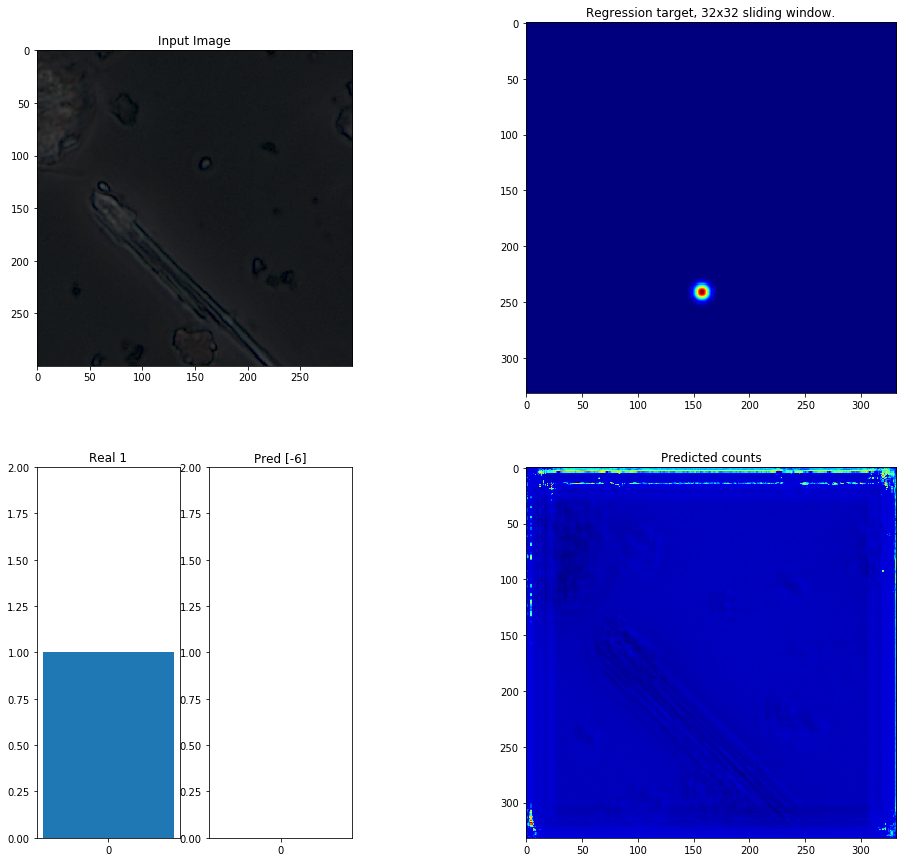

In [43]:
%matplotlib inline
processImages('test',0)

1 label est  1  --> predicted est  [-5]


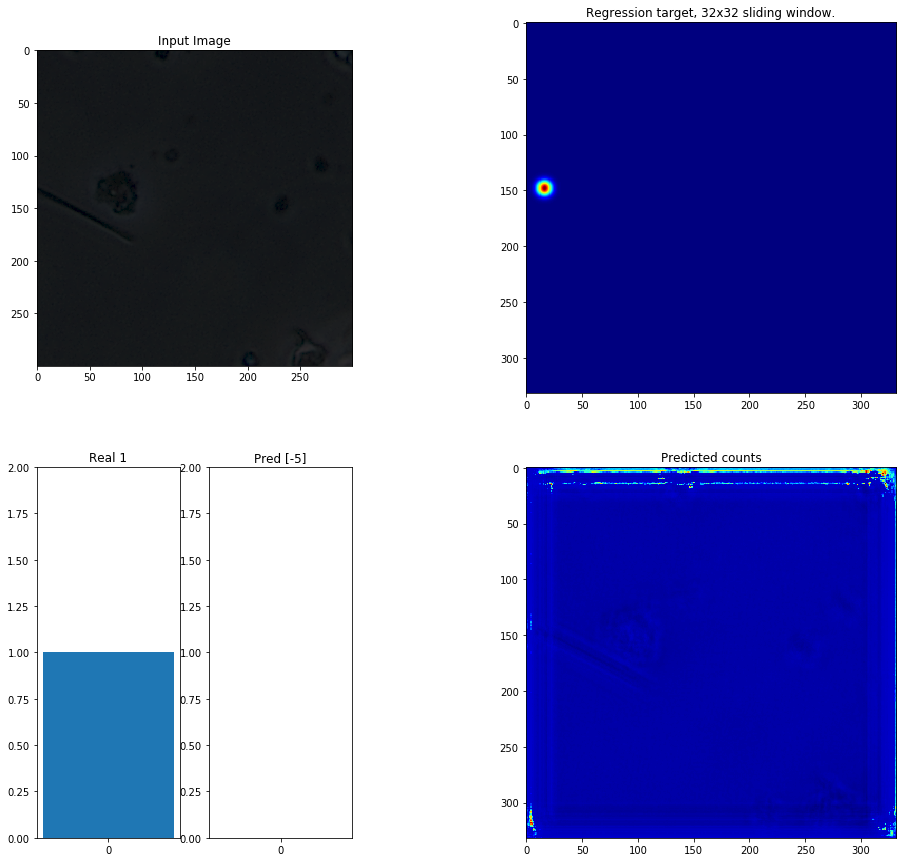

In [44]:
%matplotlib inline
processImages('test',1)

2 label est  1  --> predicted est  [-6]


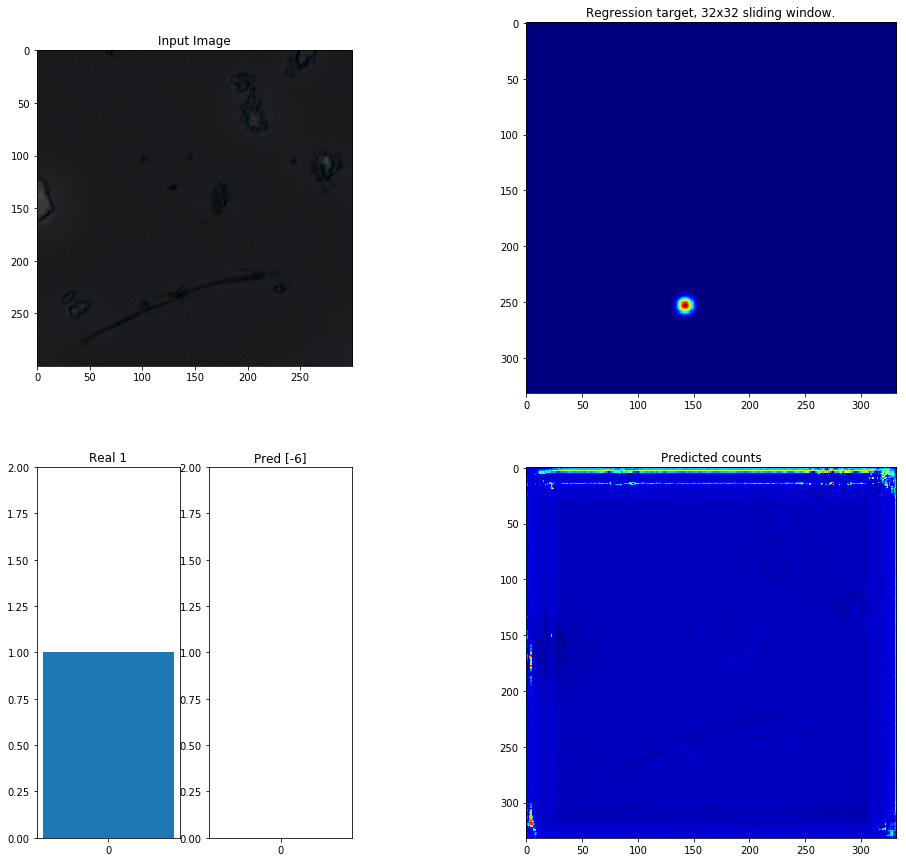

In [45]:
%matplotlib inline
processImages('test',2)

3 label est  1  --> predicted est  [-6]


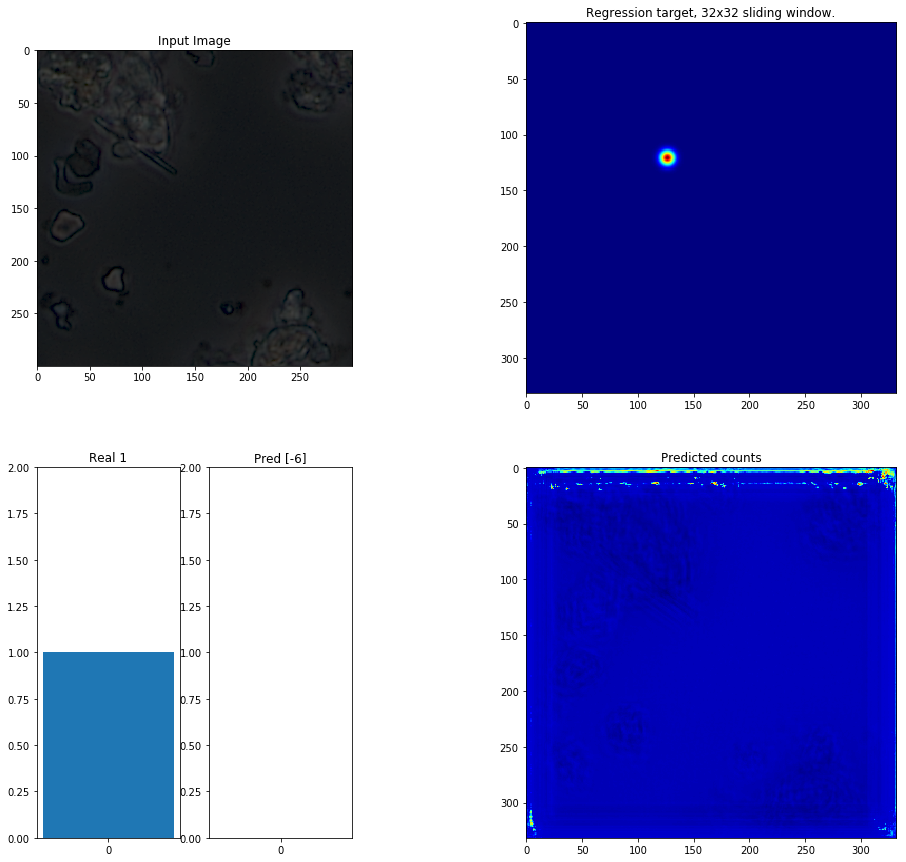

In [46]:
%matplotlib inline
processImages('test',3)

4 label est  1  --> predicted est  [-5]


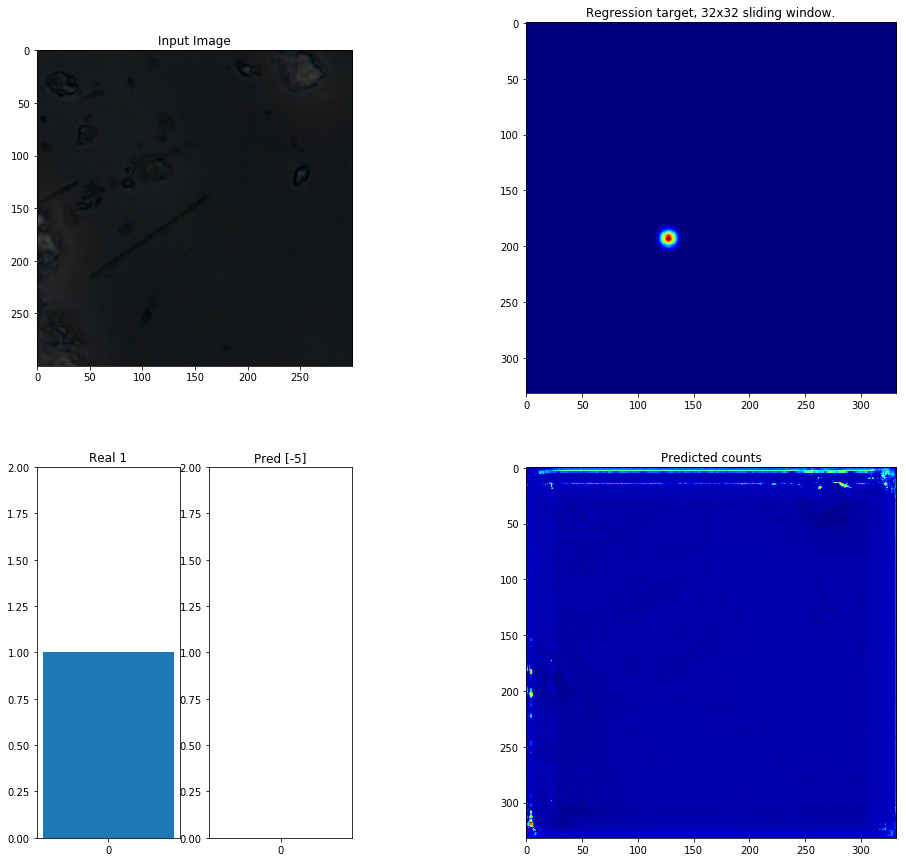

In [47]:
%matplotlib inline
processImages('test',4)

5 label est  1  --> predicted est  [-6]


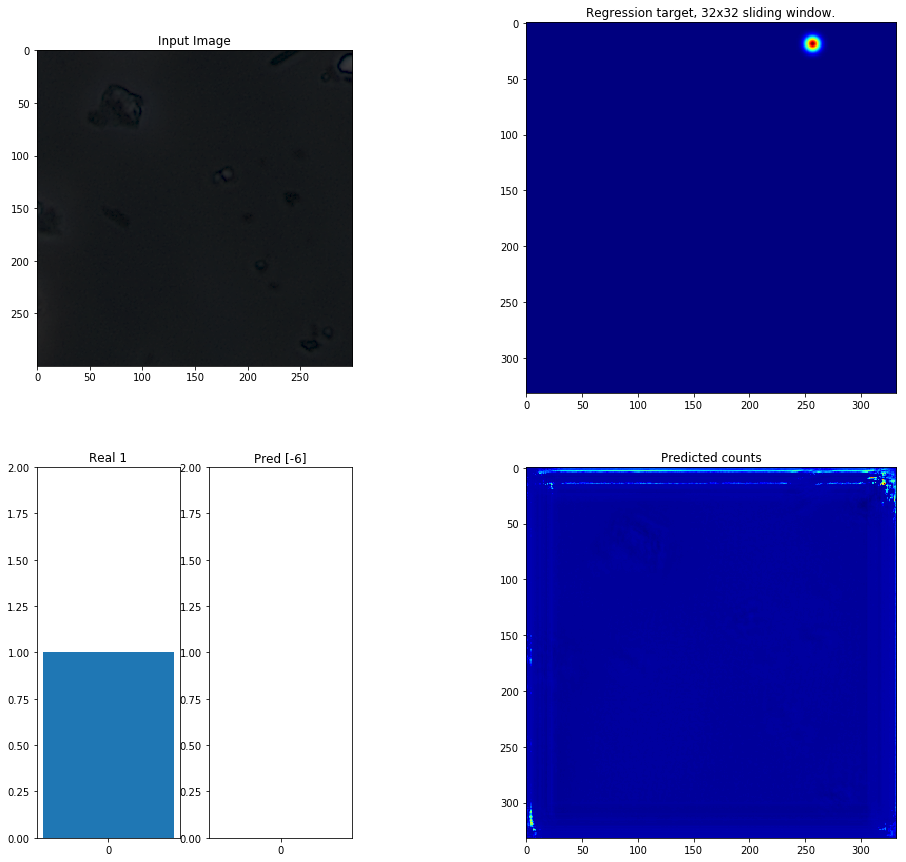

In [48]:
%matplotlib inline
processImages('test',5)

10 label est  2  --> predicted est  [-7]


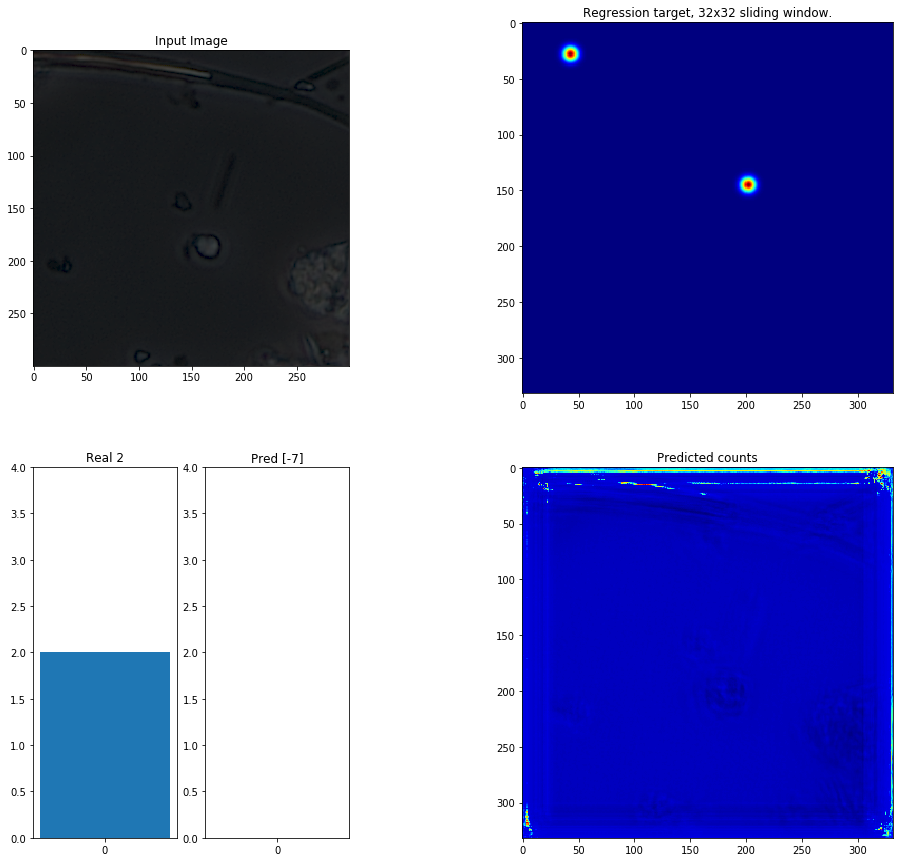

In [49]:
%matplotlib inline
processImages('test',10)